In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize


## Segédfüggvények

In [2]:
def gcd(m, n): # euclid's algorithm
    a = max(m,n)
    b = min(m,n)
    if a%b == 0:
        return a, b
    c = a % b
    return gcd(b, c) # c a legnagyobb közös osztó

# determines if n is probably-prime or composite using miller rabin test. Tests k times
def is_prime(n, k=20): # miller-rabin test
    if n == 2:
        return True
    for _ in range(k):
        witness = 1
        a = random.randint(2, n-1)
        if gcd(a, n)[1] != 1:
            return False
        d = n-1
        r = 0
        while d % 2 == 0:
            d = d//2
            r += 1
        s = int_pow_mod(a, d, n)
        if s == 1:
            witness = 0
        for i in range(r):
            if s == n-1:
                witness = 0
            s = s**2 % n
        if witness == 1:
            return False
    return True

In [3]:
def int_nth_root(A, n): # calculate floor of nth root of A
    if A<0:
        if n%2 == 0:
            raise ValueError
        return -int_nth_root(-A,n)
    if A==0:
        return 0
    n1 = n-1
    if A.bit_length() < 1024: # float(n) safe from overflow
        xk = int( round( pow(A,1.0/n) ) )
        xk = ( n1*xk + A//pow(xk,n1) )//n # Ensure xk >= floor(nthroot(A)).
    else:
        xk = 1 << -(-A.bit_length()//n) # 1 << sum(divmod(A.bit_length(),n))
                                        # power of 2 closer but greater than the nth root of A
    while True:
        d = A // pow(xk,n1)
        if xk <= d:
            return xk
        xk = (n1*xk + d)//n

In [4]:
def two_pow(A, k): # computes A**(2**k), A: L bit int
    result = np.copy(A)
    for i in range(k): # k multiplying operations
        result = result**2 
    return result  # if k < L: max O(L^3) operations

def int_pow(A, n): # computes A**n in polynomal time, A: L bit int
    n_bin = list(bin(n))
    index = n_bin.index('b')
    n_bin = n_bin[index+1:]
    l = len(n_bin) # l < log(L)
    result = 1
    for i in range(l):
        bit = int(n_bin[l-i-1])
        if bit == 1:
            result = result*two_pow(A, i)
    return result # if n < A: max O(L^4) operations

In [5]:
def two_pow_mod(A, k, N): #computes A**(2**k) mod N, A: L bit int
    result = np.copy(A)
    for i in range(k): # k multiplying operations
        result = result**2 % N
    return result  # if  k < L: max O(L^3)

def int_pow_mod(A, n, N): #computes A**n mod N in polynomal time, A: L bit integer
    n_bin = list(bin(n))
    index = n_bin.index('b')
    n_bin = n_bin[index+1:]
    l = len(n_bin) # l < log(L)
    result = 1
    for i in range(l):
        bit = int(n_bin[l-i-1])
        if bit == 1:
            result = result*two_pow_mod(A, i, N) % N
    return result # if n < A:max O(L^4) operations

In [6]:
def find_int_pow(N):
    n = N.bit_length()
    for i in range(2, n):
        a = int_nth_root(N, i)
        if int_pow(a, i) == N:
            return a, i
    return N, 1

def order(a, N): 
    if gcd(a, N)[1] != 1:
        raise ValueError("a and N have to be coprime")
    s = 1
    i = 0
    while i == 0 or s != 1:
        s = (a*s) % N
        i += 1
    return i

## Számolás és ábrakészítés

In [7]:
def fidelity(X, Y):
    if len(X) != len(Y):
        raise ValueError("X and Y have to be of equal length")
    return sum(np.sqrt(X)*np.sqrt(Y))**2
    

def geo(p, n):
    G = []
    for i in range(n+1):
        G.append(p*(1-p)**(i))
    return np.array(G)
        
def geom(k, p):
    return p*(1-p)**(k-1)

def lin(x, a, b):
    return a*x+b

def log(x, a):
    return(a*np.log2(x))

In [8]:
#természetes számokat felvevő X és Y val változók súlyfüggvényét adjuk át 'numpy array'-ként
#nem tudjuk az egész súlyfüggvényt átadni, hiszen végtelen sok értéket vehetnek fel a val változók
def distr_add(X, Y): # k jelöli a legnagyobb felvett értéket
    if len(X) != len(Y):
        raise ValueError("X and Y have to be of equal length")
    k = len(X)-1
    S = []
    for i in range(k+1):
        s = 0
        for j in range(i+1):
            s += X[j]*Y[i-j]
        S.append(s)
    return np.array(S)

def distr_mult(X, n): # n darab azonos eloszlású természetes értékű val változót ad össze
    k = len(X)-1
    if n == 0:
        S = np.zeros(k+1)
        S[0] = 1
        return S
    S = X
    for j in range(n-1):
        S = distr_add(X, S)
    return S

[0.30057593]


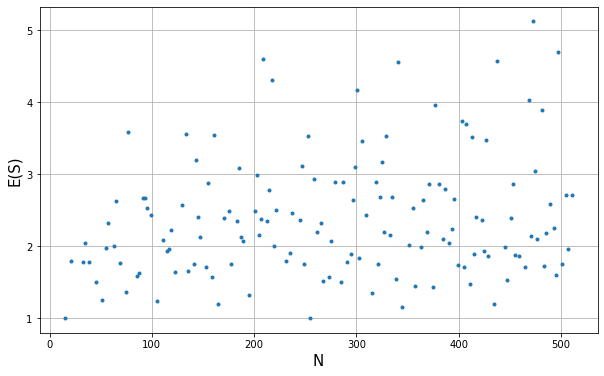

In [25]:
num = []
E = []
Expect = {}
for N in range(4, 512):
    if is_prime(N)==False and find_int_pow(N)[1] == 1 and N%2 == 1:
        num.append(N)
        
        i = 0 # itt számláljuk, hogy hány sikeres 'a' van 
        frac = []
        for a in range(2, N-1):
            if gcd(a, N)[1] == 1:
                r = order(a, N)
                j = 0
                for s in range(1, r):
                    if gcd(s, r)[1] == 1:
                        j += 1
                frac.append(r/j)
                if r%2 == 0 and int_pow_mod(a, r//2, N) != N-1:
                    i += 1
            else:
                i += 1
                
        q = i/(N-3)
        E.append(1/(q*(N-3))*sum(frac))
        Expect[N] = 1/(q*(N-3))*sum(frac)
num = np.array(num)
fit, cov = scipy.optimize.curve_fit(log, num, E, p0=[1])
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(num, E, '.')
ax.set_xlabel('N', fontsize=15)
ax.set_ylabel('E(S)', fontsize=15)
ax.grid()
#ax.plot(num, log(num, fit[0]))
print(fit)
#plt.savefig('E(S).png')

In [10]:
N = 21
p1 = []
p2 = []
j = 0 # nem sikeres 'a'-k száma
for a in range(2, N-1):
    if gcd(a, N)[1] == 1:
        r = order(a, N)
        i = 0
        for s in range(1, r):
            if gcd(s, r)[1] == 1:
                i += 1
        if r%2 == 1 or int_pow_mod(a, r//2, N) == N-1:
            p1.append(i/r)
            j += 1
        else:
            p2.append(i/r)
l = len(p1+p2)
q = (N-3-j)/(N-3)
p1 = np.array(p1)
p2 = np.array(p2)
if q != 1:
    P1 = [0]
else:
    P1 = [1]
P2 = [(N-3-l)/q/(N-3)]
j = 50
for k in range(1, j):
    if q != 1:
        P1.append(1/(1-q)/(N-3)*sum((1-p1)**(k-1)*p1))
    else:
        P1.append(0)
    P2.append(1/q/(N-3)*sum((1-p2)**(k-1)*p2))
    
fit, cov = scipy.optimize.curve_fit(geom, np.array(range(1, len(P2))), P2[1:], p0=[1])

In [11]:
j = 40
S = []
for s in range(j): # s: S által felvett érték
    p = 0
    for k in range(1, s+2): # k: K által felvett érték
        p += q*(1-q)**(k-1)*distr_add(distr_mult(P1, k-1), P2)[s]
    S.append(p)


0.9998912840153071
0.705273355456159


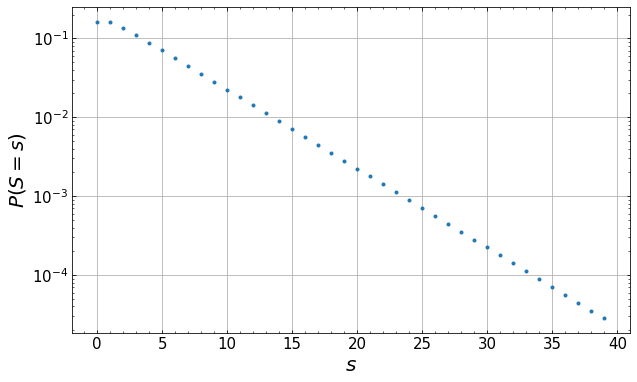

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(S)), S, '.')
ax.set_yscale('log')
ax.set_xlabel('$s$', fontsize=20)
ax.set_ylabel('$P(S=s$)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#ax.set_title('Szükséges futtatások számának (S) eloszlása N = %i esetén' % N, fontsize= 15)
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
ax.tick_params(labelsize=15, which='both', direction='in',right=True, left=True, bottom=True, top=True)
ax.grid()
print(sum(S))
print(fidelity(S, geo(0.5, len(S)-1)))
plt.savefig('eloszl21')

In [26]:
fid = []
N_fid = []
for N in range(2, 512):
    p1 = [] # adott sikertelen 'a'-khoz tartozó valószínűségek
    p2 = [] # sikeres 'a'-khoz tartozó valószínűségek
    if find_int_pow(N)[1] == 1 and N%2 != 0 and is_prime(N)==False:
        p1 = []
        p2 = []
        j = 0 # nem sikeres 'a'-k száma
        for a in range(2, N-1):
            if gcd(a, N)[1] == 1:
                r = order(a, N)
                i = 0 # 
                for s in range(1, r):
                    if gcd(s, r)[1] == 1:
                        i += 1
                if r%2 == 1 or int_pow_mod(a, r//2, N) == N-1:
                    p1.append(i/r)
                    j += 1
                else:
                    p2.append(i/r)
        l = len(p1+p2)
        q = (N-3-j)/(N-3)
        p1 = np.array(p1)
        p2 = np.array(p2)
        P1 = [0] # "X" súlyfüggvénye
        P2 = [(N-3-l)/q/(N-3)] # "Y" súlyfüggvénye
        j = 40
        for k in range(1, j):
            if q != 1:
                P1.append(1/(1-q)/(N-3)*sum((1-p1)**(k-1)*p1))
            else:
                P1.append(0)
            P2.append(1/q/(N-3)*sum((1-p2)**(k-1)*p2))
        
        S = []
        for s in range(j): # s: S által felvett érték
            p = 0
            for k in range(1, s+2): # k: K által felvett érték
                p += q*(1-q)**(k-1)*distr_add(distr_mult(P1, k-1), P2)[s]
            S.append(p)
        #fig, ax = plt.subplots(figsize=(8,5))
        #ax.plot(range(len(S)), S, '.')
        #ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
        #ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
        #ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))
        #ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.1))
        #ax.set_title('N = %i' % N, fontsize=20)
        #ax.set_xlabel('próbálkozások száma', fontsize=15)
        #ax.set_ylabel('valószínűség',fontsize=15)
        #ax.set_yscale('log')
        N_fid.append(N)
        fid.append(fidelity(geo(1/(Expect[N]+1), len(S)-1), S))
        #print('N = %i: fidelity=' %N ,fidelity(geo(1/(Expect[N]+1), len(S)-1), S))

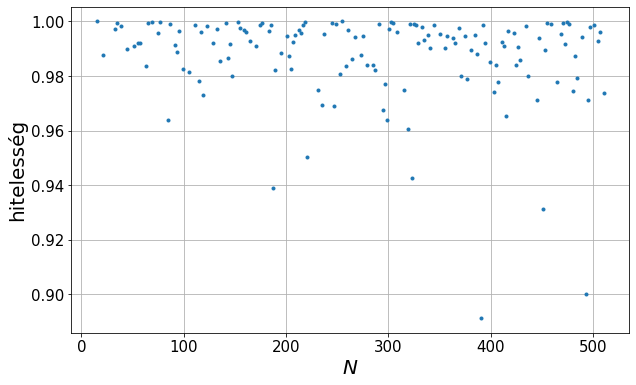

In [28]:
num = np.array(num, dtype = int)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(N_fid, fid, '.')
ax.set_xlabel('$N$', fontsize=20)
ax.set_ylabel('hitelesség', fontsize=20)
#ax.set_ylim(0.95, 1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#ax.set_title('Futtatások számának várható értéke')
ax.grid()
plt.savefig('fidelity')
